In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [30]:
data = pd.read_csv("/Data/model_exp_input_1st_growing.csv")      # Replace with your file path
new_data = pd.read_csv("Data/model_exp_input_2nd_growing.csv")   # Replace with your file path

In [31]:
# Create new features
data['height_volume_ratio'] = data['height'] / data['volume']
data['height_area_ratio'] = data['height'] / data['area']
data['volume_area_ratio'] = data['volume'] / data['area']

# Create new features in the new dataset
new_data['height_volume_ratio'] = new_data['height'] / new_data['volume']
new_data['height_area_ratio'] = new_data['height'] / new_data['area']
new_data['volume_area_ratio'] = new_data['volume'] / new_data['area']

In [32]:
X = data[['height', 'volume', 'area', 'height_volume_ratio', 'height_area_ratio', 'volume_area_ratio']]
y = data['fresh_weight']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scalers
scaler = StandardScaler()
y_scaler = MinMaxScaler()

# Fit and transform the training data, transform the testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Initialize and train the models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "Gaussian Process Regressor": GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2)), n_restarts_optimizer=10, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled.ravel())
    y_pred = model.predict(X_test_scaled)
    y_pred_original = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test_scaled, y_pred)
    r2 = r2_score(y_test_scaled, y_pred)
    results.append({'Model': name, 'MSE': mse})

# Create a dataframe to display the results
results_df = pd.DataFrame(results)
print(results_df)

                         Model       MSE
0                Decision Tree  0.259243
1                Random Forest  0.124088
2  Gradient Boosting Regressor  0.147979
3   Gaussian Process Regressor  0.160989


In [33]:
# Define features and target variable for the new dataset
X_new = new_data[['height', 'volume', 'area', 'height_volume_ratio', 'height_area_ratio', 'volume_area_ratio']]
y_new = new_data['fresh_weight']

# Scale the new dataset features
X_new_scaled = scaler.transform(X_new)

# Scale the target variable y_new
y_new_scaled = y_scaler.transform(y_new.values.reshape(-1, 1))

# Initialize lists to store predictions
predictions_scaled = []

# Predict fresh weight using each trained model
for name, model in models.items():
    y_pred_scaled = model.predict(X_new_scaled)
    predictions_scaled.append(y_pred_scaled)

# Create a dataframe to compare the scaled predictions with the scaled measured fresh weights
comparison_df_scaled = pd.DataFrame({
    'Measured Fresh Weight (Scaled)': y_new_scaled.flatten()
})

for i, name in enumerate(models.keys()):
    comparison_df_scaled[name + ' Predicted Fresh Weight (Scaled)'] = predictions_scaled[i]

new_results = []
for name, pred in zip(models.keys(), predictions_scaled):
    mse_scaled = mean_squared_error(y_new_scaled, pred)
    r2_scaled = r2_score(y_new_scaled, pred)
    new_results.append({'Model': name, 'MSE': mse_scaled})

new_results_df = pd.DataFrame(new_results)

# Print the new results dataframe
print(new_results_df)

                         Model       MSE
0                Decision Tree  0.145410
1                Random Forest  0.095747
2  Gradient Boosting Regressor  0.112989
3   Gaussian Process Regressor  0.188501


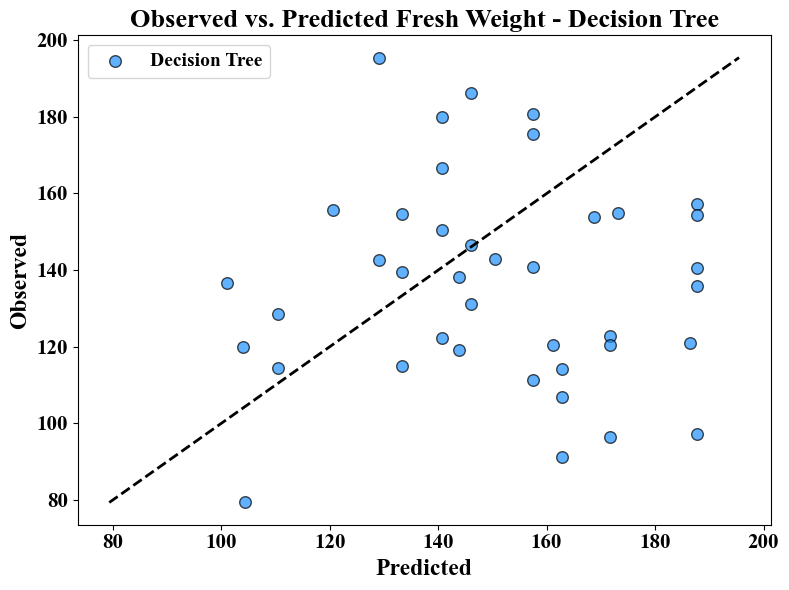

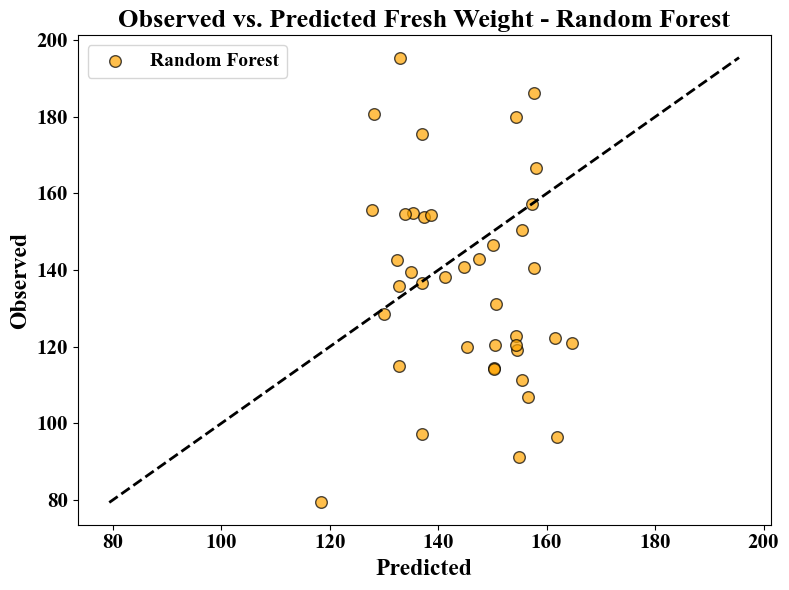

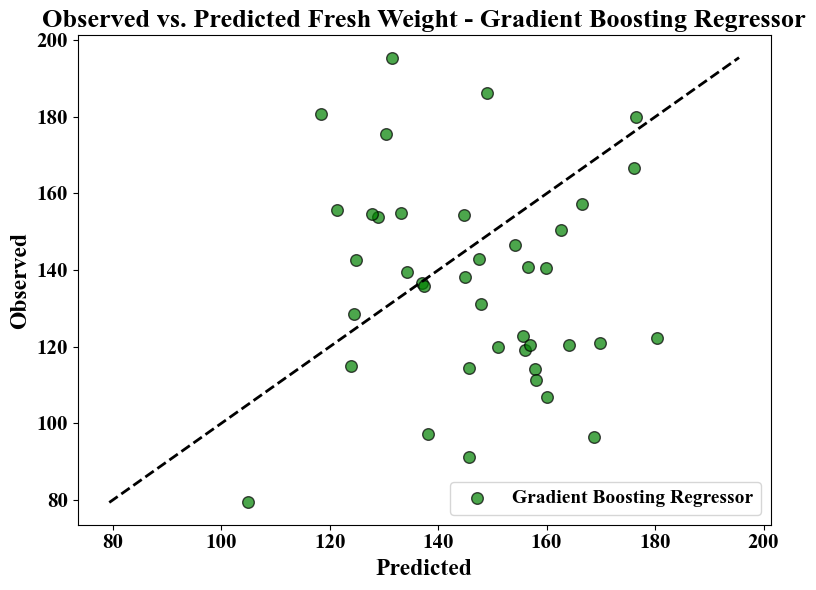

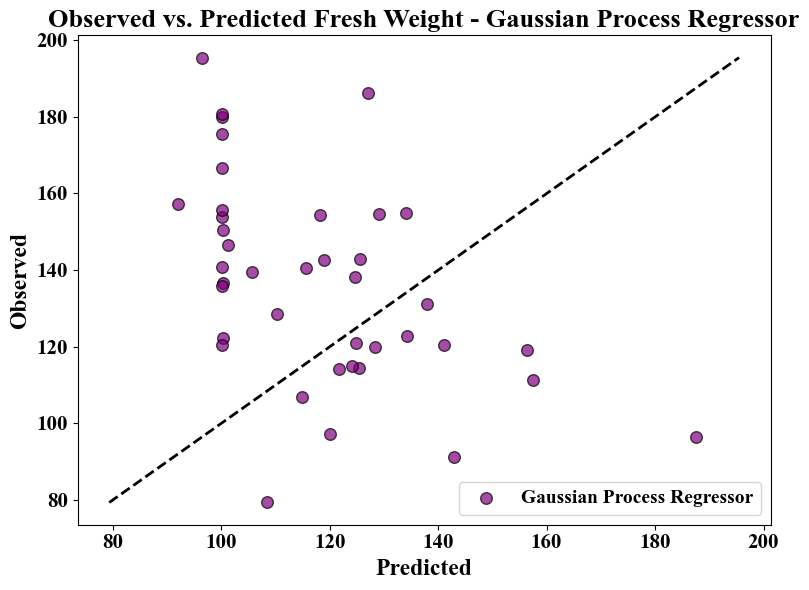

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define a color map for models
color_map = {
    'Decision Tree': 'dodgerblue',
    'Random Forest': 'orange',
    'Gradient Boosting Regressor': 'green',
    'Gaussian Process Regressor': 'purple'
}

def plot_observed_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_true, edgecolor='k', alpha=0.7, s=70, color=color_map[model_name], label=model_name)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Predicted', fontsize=17, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Observed', fontsize=17, fontweight='bold', fontname='Times New Roman')
    plt.title(f'Observed vs. Predicted Fresh Weight - {model_name}', fontsize=19, fontweight='bold', color='black', fontname='Times New Roman')
    plt.xticks(fontsize=15, fontweight='bold', fontname='Times New Roman')
    plt.yticks(fontsize=15, fontweight='bold', fontname='Times New Roman')
    plt.legend(fontsize=12, prop={'weight': 'bold', 'size': 14, 'family': 'Times New Roman'})
    plt.tight_layout()
    plt.savefig(f"Observed_vs_Predicted_{model_name.replace(' ', '_')}.png", dpi=600)
    plt.show()

# Plot observed vs. predicted for each model and save each plot
for name, pred_scaled in zip(models.keys(), predictions_scaled):
    pred = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
    plot_observed_vs_predicted(y_new, pred, name)
